In [35]:
import numpy as np
import pandas as pd

import json
import torch
from torch import nn
from tqdm import tqdm
import faiss
import sqlite3
from transformers import BertModel, BertTokenizer

# For displaying thumbnail images
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

In [2]:
class QueryEncoder(torch.nn.Module):
    def __init__(self, vocab_size, embed_dim, output_embed_dim):
        super().__init__()
        self.embedding_layer = torch.nn.Embedding(vocab_size, embed_dim)
        # Use fewer transformer layers for queries since they're shorter
        self.encoder = torch.nn.TransformerEncoder(
            torch.nn.TransformerEncoderLayer(embed_dim, nhead=8, batch_first=True),
            num_layers=2,
            norm=torch.nn.LayerNorm([embed_dim]),
            enable_nested_tensor=False
        )
        self.projection = torch.nn.Linear(embed_dim, output_embed_dim)
        
    def forward(self, tokenizer_output):
        # Move inputs to the same device as the model
        input_ids = tokenizer_output['input_ids'].to(self.embedding_layer.weight.device)
        attention_mask = tokenizer_output['attention_mask'].to(self.embedding_layer.weight.device)
        
        x = self.embedding_layer(input_ids)
        x = self.encoder(x, src_key_padding_mask=attention_mask.logical_not())
        # Use mean pooling instead of CLS token for queries
        # This helps capture information from all tokens in short queries
        mask_expanded = attention_mask.unsqueeze(-1).expand(x.size())
        sum_embeddings = torch.sum(x * mask_expanded, 1)
        sum_mask = torch.sum(mask_expanded, 1)
        mean_embeddings = sum_embeddings / sum_mask
        return self.projection(mean_embeddings)

In [3]:
class ProductEncoder(torch.nn.Module):
    def __init__(self, vocab_size, embed_dim, output_embed_dim):
        super().__init__()
        self.embedding_layer = torch.nn.Embedding(vocab_size, embed_dim)
        # Use more transformer layers for product descriptions since they're longer
        self.encoder = torch.nn.TransformerEncoder(
            torch.nn.TransformerEncoderLayer(embed_dim, nhead=8, batch_first=True),
            num_layers=4,
            norm=torch.nn.LayerNorm([embed_dim]),
            enable_nested_tensor=False
        )
        self.projection = torch.nn.Linear(embed_dim, output_embed_dim)
        
    def forward(self, tokenizer_output):
        # Move inputs to the same device as the model
        input_ids = tokenizer_output['input_ids'].to(self.embedding_layer.weight.device)
        attention_mask = tokenizer_output['attention_mask'].to(self.embedding_layer.weight.device)
        
        x = self.embedding_layer(input_ids)
        x = self.encoder(x, src_key_padding_mask=attention_mask.logical_not())
        # Use CLS token for product descriptions
        cls_embed = x[:,0,:]
        return self.projection(cls_embed)

In [29]:
# Reload Model
# loaded_model = ProductEncoder()
# loaded_model.load_state_dict(torch.load("home_products_model.pt"))
tokenizer=BertTokenizer.from_pretrained('bert-base-uncased')

query_encoder = QueryEncoder(vocab_size=tokenizer.vocab_size, embed_dim=512, output_embed_dim=128)
query_encoder.load_state_dict(torch.load("data/home_products_query_encoder.pt"))

description_encoder = ProductEncoder(vocab_size=tokenizer.vocab_size, embed_dim=512, output_embed_dim=128)
description_encoder.load_state_dict(torch.load("data/home_products_description_encoder.pt"))

<All keys matched successfully>

In [30]:
product_df = pd.read_csv('data/labeled_tools_and_home_improvement_products.csv')
product_df.head()

,id,title,description,label
0,B09M8J9LQ9,Decute 200LED Christmas String Lights Outdoor ...,Specifications Light Color Multicolored Applic...,22
1,B0BNZ888C7,Upgrade Hydro Shower Jet Head High Pressure Hy...,HighPressure Filtered Shower Head with 3 Repla...,10
2,B07TLCQ3NR,"1"" Adhesive Furniture Sliders -Furnigear Chair...",Adhesive Furniture Glides SlidersFurnigear Hea...,17
3,B09HRSKRFB,"Sunlite 40455 LED A19 Colored Light Bulb, 3 Wa...",Sunlites colored decorative A19 household ligh...,3
4,B014AV8FY2,Dixie Belle Paint Company Chalk Finish Furnitu...,CHALK MINERAL PAINT Amethyst is a rich deep m...,9


In [33]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [36]:
product_descriptions = list(product_df['description'])
product_ids = list(product_df['id'])
batch_size=128
description_encoder = description_encoder.to(device)

sample_tokens = tokenizer(
    product_descriptions[0:1], 
    padding=True,
    truncation=True,
    return_tensors="pt",
    max_length=512
)

with torch.no_grad():
    sample_embedding = description_encoder(sample_tokens)
embedding_dim = sample_embedding.shape[1]

# Create FAISS index based on requested type
index = faiss.IndexFlatIP(embedding_dim)

# Encode all products in batches and add to index
print("Encoding products and adding to index...")
batch_product_ids = []

# Create batches for product descriptions
batches = [product_descriptions[i:i + batch_size] for i in range(0, len(product_descriptions), batch_size)]
batch_ids = [product_ids[i:i + batch_size] for i in range(0, len(product_ids), batch_size)]

for batch_desc, batch_id in tqdm(zip(batches, batch_ids), total=len(batches), desc="Building index"):
    tokens = tokenizer(
        batch_desc, 
        padding=True, 
        truncation=True, 
        return_tensors="pt", 
        max_length=512
    )
    
    # Encode batch
    with torch.no_grad():
        embeddings = description_encoder(tokens)
        # Normalize embeddings for cosine similarity
        embeddings = torch.nn.functional.normalize(embeddings, p=2, dim=1)
        
    # Add to index
    index.add(embeddings.cpu().numpy())
    batch_product_ids.extend(batch_id)

print(f"Index built with {len(batch_product_ids)} products")

Encoding products and adding to index...


Building index: 100%|████████████████████████████████████████████████████████████████| 129/129 [07:42<00:00,  3.58s/it]

Index built with 16471 products


In [37]:
faiss.write_index(index, "data/home_product_embeddings.index")

In [8]:
# Load in original data to add supplemental fields
file='data/meta_Tools_and_Home_Improvement.jsonl'

products = []

with open(file, 'r') as fp:
    for line in fp:
        products.append(json.loads(line.strip()))

In [9]:
products[0]

{'main_category': 'Tools & Home Improvement',
 'title': 'Monster & Master 6" C-clamp Locking Plier without Swivel Pads, 3-Piece, MM-CP-004x3',
 'average_rating': 3.9,
 'rating_number': 168,
 'features': ['6" C-clamp locking pliers are ideal for clamping bulky work pieces.',
  'Heavy duty Chrome Vanadium steel jaws and teeth with premium wear and corrosion resistant nickel plating.',
  'Operation is as easy as turning the screw to adjust the pressure level and fit the object at hand.',
  'Classic trigger lock release securely lock the pliers in place while you work.',
  'Turn knob adjusts working pressure to lock securely at varying widths.'],
 'description': ['6" C-clamp locking pliers are ideal for clamping bulky work pieces.'],
 'price': None,
 'images': [{'thumb': 'https://m.media-amazon.com/images/I/41-IZsoY70L._AC_US75_.jpg',
   'large': 'https://m.media-amazon.com/images/I/41-IZsoY70L._AC_.jpg',
   'variant': 'MAIN',
   'hi_res': 'https://m.media-amazon.com/images/I/71nmsDlTpqL._

In [10]:
# APPEND NEW FIELDS TO DATA BY CREATING DICTIONARY WHERE KEYS ARE PARENT_ASIN AND VALUES ARE COLUMN VALUES
extra_product_info = {product['parent_asin']: [product['average_rating'], product['rating_number'], product['images'][0]['thumb'] if (len(product['images']) > 0) and ('thumb' in product['images'][0]) else '', product['store']] for product in products}

In [11]:
extra_product_df = pd.DataFrame.from_dict(extra_product_info, orient="index")

In [12]:
extra_product_df.columns = ['average_rating', 'number_of_ratings', 'thumbnail_image_link', 'store']

In [13]:
extra_product_df.head()

,average_rating,number_of_ratings,thumbnail_image_link,store
B07QQLKVQX,3.9,168,https://m.media-amazon.com/images/I/41-IZsoY70...,Monster & Master
B078RWZSYB,4.4,81,https://m.media-amazon.com/images/I/41K2XyoC7R...,PENCK
B07VH9GWPS,4.3,66,https://m.media-amazon.com/images/I/41Iizpcuvc...,SUNNY SHOWER
B07NC62X7H,5.0,1,https://m.media-amazon.com/images/I/41r9mlbg3r...,Kingston Brass
B00GIU9MVY,4.1,24,https://m.media-amazon.com/images/I/31XOUumH96...,Beme International


In [14]:
product_df = product_df.set_index('id')

In [15]:
final_df = product_df.join(extra_product_df)

In [16]:
final_df.head()

,title,description,label,average_rating,number_of_ratings,thumbnail_image_link,store
id,,,,,,,
B09M8J9LQ9,Decute 200LED Christmas String Lights Outdoor ...,Specifications Light Color Multicolored Applic...,22,4.5,1255,https://m.media-amazon.com/images/I/51c4pBrjmd...,Decute
B0BNZ888C7,Upgrade Hydro Shower Jet Head High Pressure Hy...,HighPressure Filtered Shower Head with 3 Repla...,10,3.4,1905,https://m.media-amazon.com/images/I/51Gd-3aOtf...,Besititli
B07TLCQ3NR,"1"" Adhesive Furniture Sliders -Furnigear Chair...",Adhesive Furniture Glides SlidersFurnigear Hea...,17,3.9,1454,https://m.media-amazon.com/images/I/419SB+TlHK...,Furnigear
B09HRSKRFB,"Sunlite 40455 LED A19 Colored Light Bulb, 3 Wa...",Sunlites colored decorative A19 household ligh...,3,4.7,2352,https://m.media-amazon.com/images/I/41PWcd7cRl...,Sunlite
B014AV8FY2,Dixie Belle Paint Company Chalk Finish Furnitu...,CHALK MINERAL PAINT Amethyst is a rich deep m...,9,4.7,8455,https://m.media-amazon.com/images/I/41p0rJfu95...,Dixie Belle Paint Company


In [42]:
# Create SQL Connection
conn = sqlite3.connect("home_product_embeddings.db")
cursor = conn.cursor()

cursor.execute("DROP TABLE IF EXISTS products")

# CREATE SQL TABLE
cursor.execute("""
    CREATE TABLE products (
        id TEXT PRIMARY KEY,
        product_name TEXT,
        seller TEXT,
        product_description TEXT,
        num_ratings INTEGER,
        avg_rating REAL,
        image_link TEXT
    )
    """)
conn.commit()

# POPULATE SQL TABLE WITH PRODUCT DATA
for row in final_df.itertuples(index=True, name=None):
    prod_id, prod_name, prod_desc, _, avg_rating, num_rating, image_url, store = row
    cursor.execute(
        """INSERT OR REPLACE INTO products
        (id, product_name, seller, product_description, num_ratings, avg_rating, image_link) VALUES (?, ?, ?, ?, ?, ?, ?)""",
        (prod_id, prod_name, store, prod_desc, num_rating, avg_rating, image_url)
    )
conn.commit()

In [45]:
res = cursor.execute("SELECT * FROM products LIMIT 1")
res.fetchall()

[('B09M8J9LQ9',
  'Decute 200LED Christmas String Lights Outdoor Waterproof 66FT with End-to-End Plug 8 Modes, Indoor Starry Fairy Lights for Christmas Tree Patio Garden Wedding Party Decor, Multicolored',
  'Decute',
  'Specifications Light Color Multicolored Application IndoorOutdoor LED Quantity 200 LED String Length 76ft  23m Work Mode 8 lighting modes Input Voltage 120V Output Voltage 30V Waterproof Rate IP55 Wire Length to First LED 99ft  3m LED Spacing 03ft  01m 8 Modes This string lights come with 8 lighting modes  Combination  In Waves  Sequential  SloGlo  ChasingFlash  Slow Fade  TwinkleFlash  Steay On IP55 Waterproof For Indoor And Outdoor High waterproof rank make it suitable for indoor and outdoor use Such as Wedding Holiday Christmas Garden YardLawn Fence Porch Tree Roof Deck and so on Max 4 Sets Expandable Each fairy light comes with end plug which makes you can connect them together Please notice that max 4 sets can be connected together Length of each string lights is 

In [106]:
def search(query, product_embeddings, k=10):
    query_tokens = tokenizer(
        query, 
        padding=True, 
        truncation=True, 
        return_tensors="pt", 
        max_length=32
    )
    
    with torch.no_grad():
        query_embedding = query_encoder(query_tokens)
        query_embedding = torch.nn.functional.normalize(query_embedding, p=2, dim=1)
    
    similarities, indices = product_embeddings.search(query_embedding.cpu().numpy(), k)
    
    similarities = similarities.reshape(-1)
    indices = indices.reshape(-1)
    top_product_ids = list(final_df.index[indices])
    
    placeholders = ', '.join(['?'] * len(top_product_ids))
    query = f"SELECT id, product_name, product_description, seller, image_link FROM products WHERE id IN ({placeholders})"
    res = cursor.execute(query, top_product_ids)
    query_results = res.fetchall()
    
    results = [{
        'product_id': query_result[0],
        'product_name': query_result[1],
        'product_description': query_result[2],
        'seller': query_result[3],
        'image_url': query_result[4],
        'similarity_score': similarity
    } for query_result, similarity in zip(query_results, similarities)]
    
    return results

In [48]:
# Read in index
index = faiss.read_index("data/home_product_embeddings.index")

In [128]:
search_results = search("Outdoor lights for winter holidays", index)

Product Name: Outdoor String Lights 25Feet (2 Pack) G40 Globe Patio Lights with 52 Edison Glass Bulbs(2 Spare), Waterproof Connectable Hanging Balcony Lights for Backyard Porch Cafe Decor, E12 Socket Base, Black


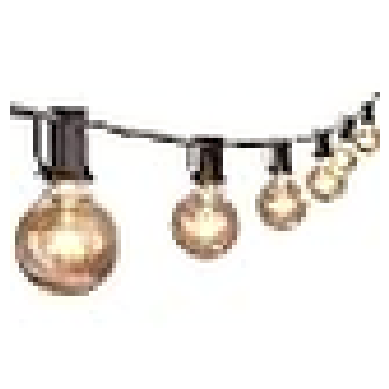

Product Name: iNextStation Neon LED Strip Light 16.4ft/5m Neon Light Strip 12V Silicone LED Neon Rope Light Waterproof Flexible LED Neon Lights for Bedroom Indoors Outdoors, Green (Power Adapter not Included)


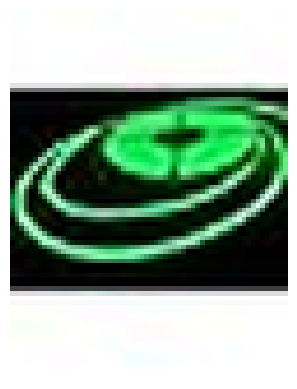

Product Name: AmeriTop Solar Lights Outdoor, 2 Pack 128 High Brightness LED Cordless Solar Motion Sensor Lights; 3 Adjustable Heads, 270°Wide Angle Illumination, IP65 Waterproof, Security LED Flood Light(Daylight)


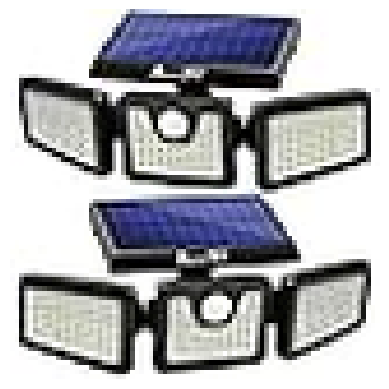

Product Name: ECOPlugs Outdoor Light Timer Outlet waterproof, Christmas Lights Timer Outlet Switch, Electrical Outlet Timers Programmable Outdoor


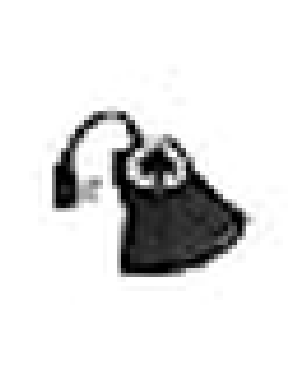

Product Name: GoLine Galaxy Projector Light, Star Projector for Bedroom, Christmas Birthday Gifts for Men Women Teen Girls Boys, Nebula Projector Night Light with Bluetooth Speaker for Party Room Decoration.


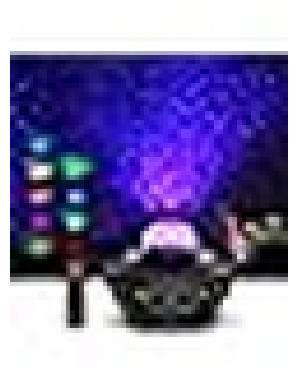

Product Name: Auhafaly Garden Shower Light Solar Powered Watering Can with Star LED Outdoor Fairy Waterfall with Bracket for Home Path Patio Yard Lawn, White


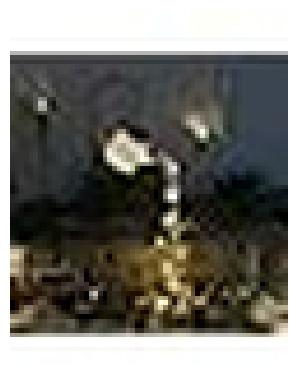

Product Name: Circle (Pack of 8) Incandescent 60 Watt A19 Light Bulb: Clear Standard Household E26 Medium Base Rough Service Light Bulbs


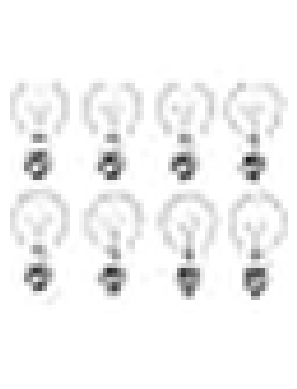

Product Name: Govee Outdoor Ground Lights, IP67 Low Voltage Pathway Lights 36ft, RGBIC Multicolor with Warm White, 15 Pack, App Control Walkway Lights for Garden Lawn with 43 Scene Modes, Sync with Music, 80 LM


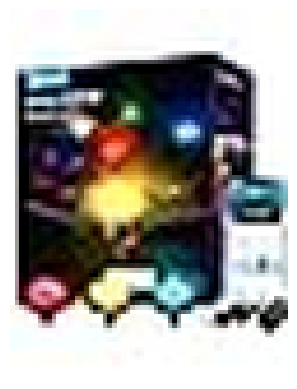

Product Name: LB1 Smart LED Bulb, WiFi Dimmable Light Bulb Compatible with Alexa and Google Home, E26 A19 Warm White 2700K 800 Lumens 8W, App Go_sund Control, No Hub Required, 2.4GHz WiFi Only, 2 Pack


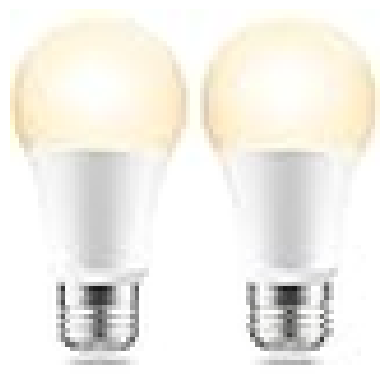

Product Name: GIGALUMI 16 Pack Solar Path Lights Outdoor,Solar Lights Outdoor Waterproof,Stainless Steel LED Landscape Lighting,Solar Garden Lights for Driveway,Pathway,Patio,Yard


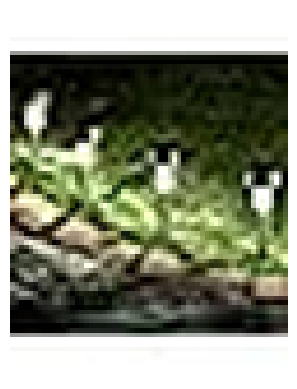

In [129]:
for result in search_results:
    # URL of the image
    image_url = result['image_url']
    
    # Fetch the image
    response = requests.get(image_url)
    img = Image.open(BytesIO(response.content))
    
    target_size = (80, 80)

    # Calculate the aspect ratio
    img_ratio = img.width / img.height
    target_ratio = target_size[0] / target_size[1]
    
    if img_ratio > target_ratio:
        # Scale based on width
        new_width = target_size[0]
        new_height = int(new_width / img_ratio)
    else:
        # Scale based on height
        new_height = target_size[1]
        new_width = int(new_height * img_ratio)
    
    # Resize the image while maintaining the aspect ratio
    img_resized = img.resize((new_width, new_height), Image.LANCZOS)

    print(f"Product Name: {result['product_name']}")
    # Display the resized image
    plt.imshow(img_resized)
    plt.axis('off')  # Hide the axes
    plt.show()